In [29]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import webbrowser
%load_ext tensorboard

# Import datasets module from TensorFlow
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import tanh 


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:

# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# had to change from 64 or else the program crashed from insufficiend memory
train_images = train_images.astype('float32')  # Converts the data type of the train_images array to 32-bit floating-point numbers 
test_images = test_images.astype('float32')    # Converts the data type of the test_images array to 32-bit floating-point numbers 

# Normalize pixel values to be between 0 and 1 
train_images, test_images = train_images / 255.0, test_images / 255.0


# Check shape of training images
print("Training images shape:", train_images.shape)
# Training images shape: (50000, 32, 32, 3)

# Check shape of test images
print("Test images shape:", test_images.shape)
# Test images shape: (10000, 32, 32, 3)


Training images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)


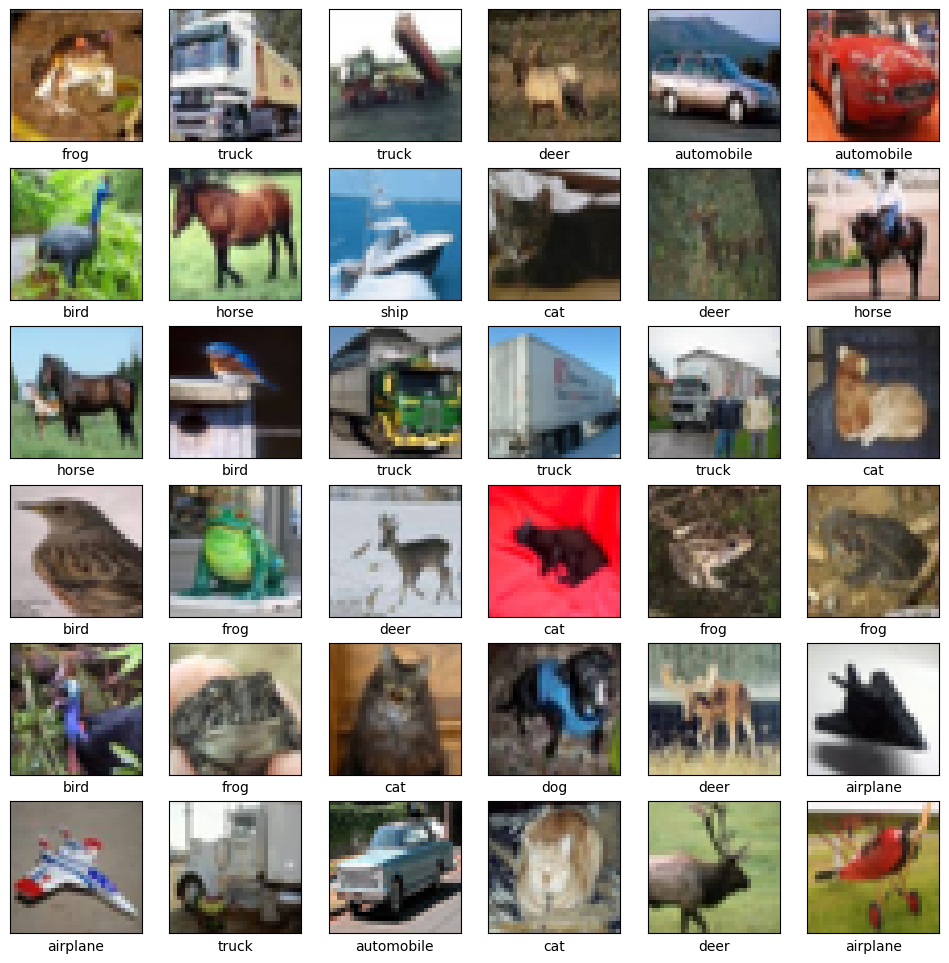

In [3]:
# visualizing dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
#######################################
#   Make sure the images exist 
#######################################
plt.figure(figsize=(12,12))   
for i in range(36):
    plt.subplot(6,6,i+1)  # subplots are indexed starting from 1, not 0
    plt.xticks([])        # Removes ticks for x-axis
    plt.yticks([])        # Removes ticks for y axis 
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])    # The CIFAR labels are arrays, start at 0
plt.show()

Epoch 1/100
1563/1563 [==============================] - 24s 15ms/step - loss: 2.2783 - accuracy: 0.1494 - val_loss: 2.2390 - val_accuracy: 0.2072
Epoch 2/100
1563/1563 [==============================] - 21s 13ms/step - loss: 2.1642 - accuracy: 0.2310 - val_loss: 2.0791 - val_accuracy: 0.2625
Epoch 3/100
1563/1563 [==============================] - 21s 13ms/step - loss: 2.0024 - accuracy: 0.2921 - val_loss: 1.9400 - val_accuracy: 0.3107
Epoch 4/100
1563/1563 [==============================] - 21s 13ms/step - loss: 1.9077 - accuracy: 0.3315 - val_loss: 1.8727 - val_accuracy: 0.3534
Epoch 5/100
1563/1563 [==============================] - 21s 14ms/step - loss: 1.8440 - accuracy: 0.3598 - val_loss: 1.8134 - val_accuracy: 0.3722
Epoch 6/100
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7814 - accuracy: 0.3819 - val_loss: 1.7456 - val_accuracy: 0.3926
Epoch 7/100
1563/1563 [==============================] - 21s 13ms/step - loss: 1.7185 - accuracy: 0.4018 - val_loss: 1

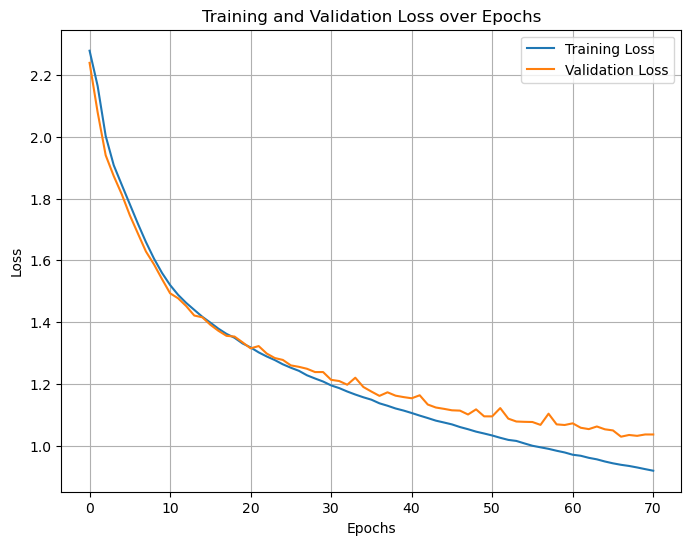

In [20]:

###################################################################
# Alpha: 0.01	    Very small leak, Default in TensorFlow/Keras
#        0.1–0.3	Moderate leak
#        0.0	    Equivalent to ReLU
# Padding = 'same'  Ensures that the output feature map (image) has the same spatial dimensions (height × width) as the input
#                   Adds zero-padding (border of zeros) around the input to preserve spatial dimensions.
###################################################################

###################################################################
#### use SGD as the optimizer and 0.0001 as the learning rate  ####
###################################################################


def Convolution(input_tensor, filters):
    convolved_features = layers.Conv2D(filters=filters,
                      kernel_size=(3,3),
                      padding='same',
                      strides=(1,1),
                      kernel_regularizer=l2(0.0001)
                     ) (input_tensor)
    activated_features  = layers.LeakyReLU(alpha=0.01) (convolved_features)
    return activated_features 
    

# Define CNN model
def simpleCNN(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    conv1 = Convolution(inputs, 16)
    maxp1 = layers.MaxPooling2D(pool_size=(2,2))(conv1)
    conv2 = Convolution(maxp1, 64)
    maxp2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)
    #conv3 = Convolution(maxp2, 64)
    #maxp3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)
    #conv4 = Convolution(maxp3, 64)
    #maxp4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)
    
    flatten = layers.Flatten()(maxp2)
    
    dense = layers.Dense(64)(flatten)
    activate_dense = layers.LeakyReLU(alpha=0.3)(dense)
    
    output = layers.Dense(10)(activate_dense)  # No activation (using from_logits=True)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model


# Ensure a new model is always created
model = simpleCNN((32, 32, 3))

# Define optimizer
optimizer = SGD(learning_rate=0.0001, momentum=0.9)

#############################################################################
# Without Momentum                           With Momentum
# Makes small, oscillating steps             Accelerates in consistent directions
# Gets stuck easily	                         Can roll through shallow minima
# Overly sensitive to small fluctuations	 Smoothens update directions

# (higher = more inertia) 0.9 widely used, Provides strong acceleration without overshooting.
#############################################################################

# Compile model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# Train the model with early stopping and batch size specification
history = model.fit(
    train_images, train_labels,
    epochs=100,
    batch_size=32,  # Set batch size
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print(f"\nBest Test Accuracy: {test_acc:.4f}")


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
1563/1563 [==============================] - 25s 15ms/step - loss: 1.6626 - accuracy: 0.4154 - val_loss: 1.4375 - val_accuracy: 0.4994
Epoch 2/100
1563/1563 [==============================] - 23s 14ms/step - loss: 1.3493 - accuracy: 0.5298 - val_loss: 1.2870 - val_accuracy: 0.5514
Epoch 3/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.2386 - accuracy: 0.5704 - val_loss: 1.1997 - val_accuracy: 0.5867
Epoch 4/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.1673 - accuracy: 0.5963 - val_loss: 1.1529 - val_accuracy: 0.5989
Epoch 5/100
1563/1563 [==============================] - 24s 16ms/step - loss: 1.1139 - accuracy: 0.6158 - val_loss: 1.1232 - val_accuracy: 0.6091
Epoch 6/100
1563/1563 [==============================] - 23s 15ms/step - loss: 1.0728 - accuracy: 0.6316 - val_loss: 1.0800 - val_accuracy: 0.6323
Epoch 7/100
1563/1563 [==============================] - 24s 16ms/step - loss: 1.0363 - accuracy: 0.6435 - val_loss: 1

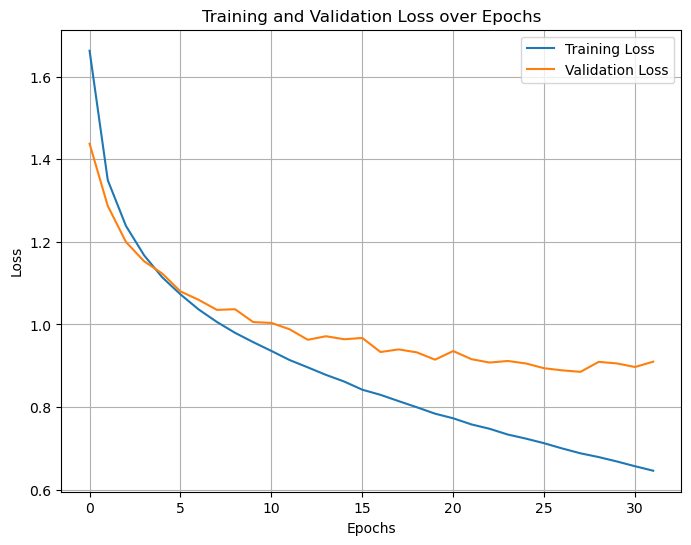

In [27]:
###################################################################
# Alpha: 0.01	    Very small leak, Default in TensorFlow/Keras
#        0.1–0.3	Moderate leak
#        0.0	    Equivalent to ReLU
# Padding = 'same'  Ensures that the output feature map (image) has the same spatial dimensions (height × width) as the input
#                   Adds zero-padding (border of zeros) around the input to preserve spatial dimensions.
###################################################################


################################
#####  optimiser to Adam  ###### 
################################



def Convolution(input_tensor, filters):
    convolved_features = layers.Conv2D(filters=filters,
                      kernel_size=(3,3),
                      padding='same',
                      strides=(1,1),
                      kernel_regularizer=l2(0.0001)
                     ) (input_tensor)
    activated_features  = layers.LeakyReLU(alpha=0.01) (convolved_features)
    return activated_features 
    

# Define CNN model
def simpleCNN(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    conv1 = Convolution(inputs, 16)
    maxp1 = layers.MaxPooling2D(pool_size=(2,2))(conv1)
    conv2 = Convolution(maxp1, 64)
    maxp2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)
    #conv3 = Convolution(maxp2, 64)
    #maxp3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)
    #conv4 = Convolution(maxp3, 64)
    #maxp4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)
    
    flatten = layers.Flatten()(maxp2)
    
    dense = layers.Dense(64)(flatten)
    activate_dense = layers.LeakyReLU(alpha=0.3)(dense)
    
    output = layers.Dense(10)(activate_dense)  # No activation (using from_logits=True)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model


# Ensure a new model is always created
model = simpleCNN((32, 32, 3))

# Define optimizer - Changed to Adam
optimizer = Adam(learning_rate=0.0001)

#############################################################################
# Without Momentum                           With Momentum
# Makes small, oscillating steps             Accelerates in consistent directions
# Gets stuck easily	                         Can roll through shallow minima
# Overly sensitive to small fluctuations	 Smoothens update directions

# (higher = more inertia) 0.9 widely used, Provides strong acceleration without overshooting.
#############################################################################

# Compile model with Adam optimizer
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# Train the model with early stopping and batch size specification
history = model.fit(
    train_images, train_labels,
    epochs=100,  # Set to 20 epochs to better visualize the changes
    batch_size=32,  # Set batch size
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print(f"\nTest Accuracy: {test_acc:.4f}")


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
1563/1563 [==============================] - 27s 17ms/step - loss: 1.7397 - accuracy: 0.3848 - val_loss: 1.5287 - val_accuracy: 0.4591
Epoch 2/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4504 - accuracy: 0.4905 - val_loss: 1.3746 - val_accuracy: 0.5096
Epoch 3/100
1563/1563 [==============================] - 24s 16ms/step - loss: 1.3213 - accuracy: 0.5365 - val_loss: 1.2686 - val_accuracy: 0.5510
Epoch 4/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2324 - accuracy: 0.5692 - val_loss: 1.2008 - val_accuracy: 0.5791
Epoch 5/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1660 - accuracy: 0.5956 - val_loss: 1.1604 - val_accuracy: 0.5927
Epoch 6/100
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1129 - accuracy: 0.6141 - val_loss: 1.1187 - val_accuracy: 0.6078
Epoch 7/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.0682 - accuracy: 0.6317 - val_loss: 1

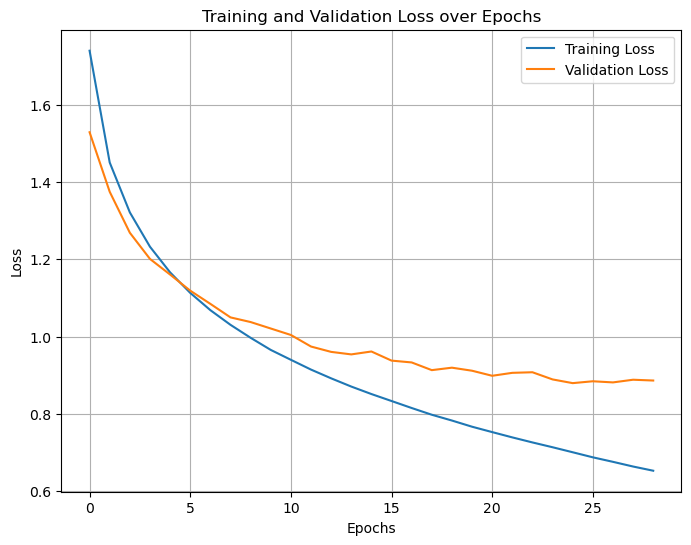

In [33]:
def Convolution(input_tensor, filters):
    convolved_features = layers.Conv2D(filters=filters,
                      kernel_size=(3,3),
                      padding='same',
                      strides=(1,1),
                      kernel_regularizer=l2(0.0001)
                     ) (input_tensor)
    activated_features  = layers.Activation(tanh)(convolved_features)  # Using tanh activation
    return activated_features 
    

# Define CNN model
def simpleCNN(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    conv1 = Convolution(inputs, 16)
    maxp1 = layers.MaxPooling2D(pool_size=(2,2))(conv1)
    conv2 = Convolution(maxp1, 48)
    maxp2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Convolution(maxp2, 64)
    maxp3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)
    conv4 = Convolution(maxp3, 64)
    maxp4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)
    
    flatten = layers.Flatten()(maxp3)
    
    dense = layers.Dense(64)(flatten)
    activate_dense = layers.Activation(tanh)(dense)  # Using tanh activation
    
    output = layers.Dense(10)(activate_dense)  # No activation (using from_logits=True)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model


# Ensure a new model is always created
model = simpleCNN((32, 32, 3))

# Define optimizer - Using Adam as in previous experiment
optimizer = Adam(learning_rate=0.0001)

# Compile model with Adam optimizer
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# Train the model with early stopping and batch size specification
history = model.fit(
    train_images, train_labels,
    epochs=100,     # Set to 100 epochs to better visualize the changes
    batch_size=32,  # Set batch size
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print(f"\nTest Accuracy: {test_acc:.4f}")


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()